In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# from datasets import load_dataset
import pandas as pd
from transformers import AutoTokenizer

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk import FreqDist
from nltk.util import ngrams
from collections import Counter
import nltk
import torch

In [4]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/rammanyala/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/rammanyala/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [5]:
# dataset  = load_dataset("EdinburghNLP/xsum")

In [6]:
dataset = pd.read_csv("FD_IN-Abs_CLS_BK.csv")

In [7]:
# df = pd.DataFrame(dataset['train'])
df = dataset
df.head()

,id,document,summary
0,0,Even if he had made an enquiry in connection w...,In both cases of sanction and direction to pro...
1,1,"Section 7(d), as it stood at the material time...",His nomination for election to the Bihar Legis...
2,2,The High Court accordingly took the view that ...,"Further, the appellant was also a maufidar in ..."
3,3,It further provides that an inamdar in respect...,coming into force of the Bombay Personal Inams...
4,4,It is against this order that the present appe...,The classification of public servants who were...


# EDA and Preprocessing

In [8]:
def display_feature_list(features, feature_type):
    print(f"\n{feature_type} Features: ")
    print(', '.join(features) if features else 'None')

def describe_df(df):
    global categorical_features, continuous_features, binary_features
    categorical_features = [col for col in df.columns if df[col].dtype == 'object']
    binary_features = [col for col in df.columns if df[col].nunique() <= 2 and df[col].dtype != 'object']
    continuous_features = [col for col in df.columns if df[col].dtype != 'object' and col not in binary_features]

    print(f"\n{type(df).__name__} shape: {df.shape}")
    print(f"\n{df.shape[0]:,.0f} samples")
    print(f"\n{df.shape[1]:,.0f} attributes")
    print(f'\nMissing Data: \n{df.isnull().sum()}')
    print(f'\nDuplicates: {df.duplicated().sum()}')
    print(f'\nData Types: \n{df.dtypes}')

    #negative_valued_features = [col for col in df.columns if (df[col] < 0).any()]
    #print(f'\nFeatures with Negative Values: {", ".join(negative_valued_features) if negative_valued_features else "None"}')

    display_feature_list(categorical_features, 'Categorical')
    display_feature_list(continuous_features, 'Continuous')
    display_feature_list(binary_features, 'Binary')

    print(f'\n{type(df).__name__} Head: \n')
    display(df.head(5))
    print(f'\n{type(df).__name__} Tail: \n')
    display(df.tail(5))

In [9]:
describe_df(df)


DataFrame shape: (461, 3)

461 samples

3 attributes

Missing Data: 
id          0
document    0
summary     0
dtype: int64

Duplicates: 0

Data Types: 
id           int64
document    object
summary     object
dtype: object

Categorical Features: 
document, summary

Continuous Features: 
id

Binary Features: 
None

DataFrame Head: 



,id,document,summary
0,0,Even if he had made an enquiry in connection w...,In both cases of sanction and direction to pro...
1,1,"Section 7(d), as it stood at the material time...",His nomination for election to the Bihar Legis...
2,2,The High Court accordingly took the view that ...,"Further, the appellant was also a maufidar in ..."
3,3,It further provides that an inamdar in respect...,coming into force of the Bombay Personal Inams...
4,4,It is against this order that the present appe...,The classification of public servants who were...



DataFrame Tail: 



,id,document,summary
456,456,All questions which may legiti mately be raise...,"Held, that the Proceedings initiated before a ..."
457,457,160 of 1952. Contempt of Court proceedings aga...,referred to.Politics and policies have no plac...
458,458,"Subsequent to the filing of the suit, the Boar...",The respondent as the aradanaikar and trustee ...
459,459,(2) The Courts were not justified in allowing ...,"Held, that although it was not permissible und..."
460,460,The first question is one of fact. The learned...,The matters came up to the High Court.Athan Sa...


In [10]:
# # Train split
# train_df = pd.DataFrame(dataset['train'])
# train_df.to_csv("xsum_train.csv", index=False)

# # Test split
# test_df = pd.DataFrame(dataset['test'])
# test_df.to_csv("xsum_test.csv", index=False)

# # Validation split
# validation_df = pd.DataFrame(dataset['validation'])
# validation_df.to_csv("xsum_validation.csv", index=False)

# print("Datasets saved as CSV files.")

In [11]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large")

In [12]:
# Initialize the tokenizer (use the tokenizer corresponding to your model)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define the preprocessing function
def preprocess_function(examples):
    # Tokenize the 'document' and 'summary' columns
    return tokenizer(examples['document'], examples['summary'], truncation=True, padding=True, max_length=512)

# Apply the preprocessing function to the DataFrame (apply to rows, not batch)
tokenized_inputs = df.apply(lambda row: preprocess_function(row), axis=1)

# Convert the tokenized inputs to appropriate columns
df['input_ids'] = tokenized_inputs.apply(lambda x: x['input_ids'])
df['attention_mask'] = tokenized_inputs.apply(lambda x: x['attention_mask'])
df['labels'] = df['input_ids']  # Assuming you're using the input_ids as labels for training

# Remove unnecessary columns
df = df.drop(columns=['document', 'summary', 'id'])

# Convert columns to PyTorch tensors
df['input_ids'] = df['input_ids'].apply(torch.tensor)
df['attention_mask'] = df['attention_mask'].apply(torch.tensor)
df['labels'] = df['labels'].apply(torch.tensor)

# Now the DataFrame is ready for use in training
print(df.head())

                                           input_ids  \
0  [tensor(101), tensor(2130), tensor(2065), tens...   
1  [tensor(101), tensor(2930), tensor(1021), tens...   
2  [tensor(101), tensor(1996), tensor(2152), tens...   
3  [tensor(101), tensor(2009), tensor(2582), tens...   
4  [tensor(101), tensor(2009), tensor(2003), tens...   

                                      attention_mask  \
0  [tensor(1), tensor(1), tensor(1), tensor(1), t...   
1  [tensor(1), tensor(1), tensor(1), tensor(1), t...   
2  [tensor(1), tensor(1), tensor(1), tensor(1), t...   
3  [tensor(1), tensor(1), tensor(1), tensor(1), t...   
4  [tensor(1), tensor(1), tensor(1), tensor(1), t...   

                                              labels  
0  [tensor(101), tensor(2130), tensor(2065), tens...  
1  [tensor(101), tensor(2930), tensor(1021), tens...  
2  [tensor(101), tensor(1996), tensor(2152), tens...  
3  [tensor(101), tensor(2009), tensor(2582), tens...  
4  [tensor(101), tensor(2009), tensor(2003), tens..

# Visualisation

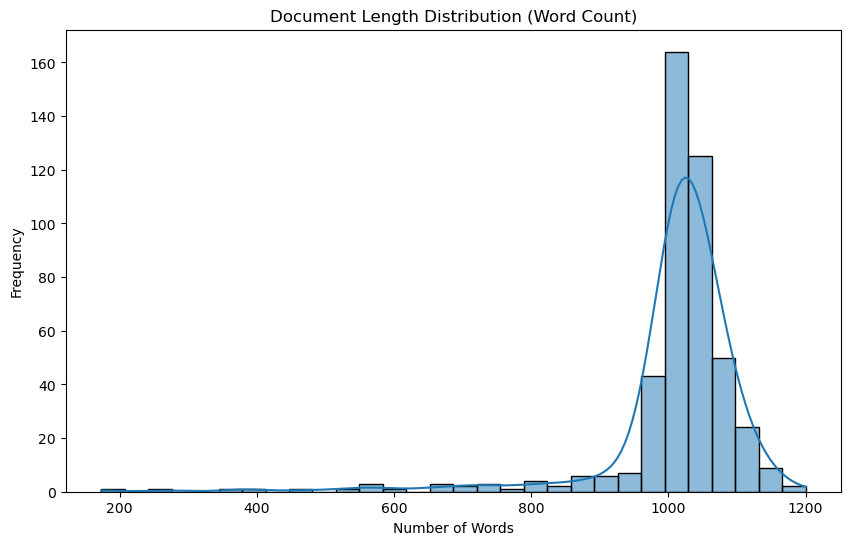

In [13]:
# Text Length Distribution (Documents)
dataset['doc_length'] = dataset['document'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(dataset['doc_length'], bins=30, kde=True)
plt.title('Document Length Distribution (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


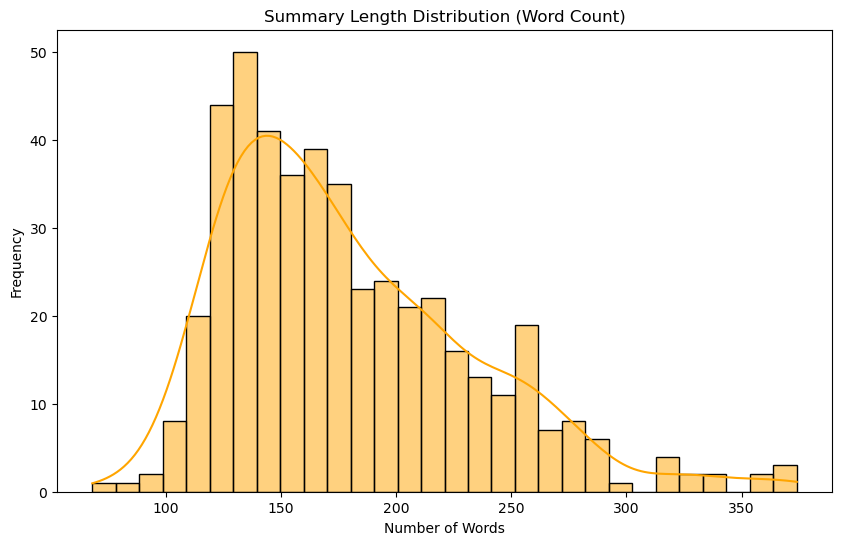

In [14]:
# Text Length Distribution (Summaries)
dataset['summary_length'] = dataset['summary'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(dataset['summary_length'], bins=30, kde=True, color='orange')
plt.title('Summary Length Distribution (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

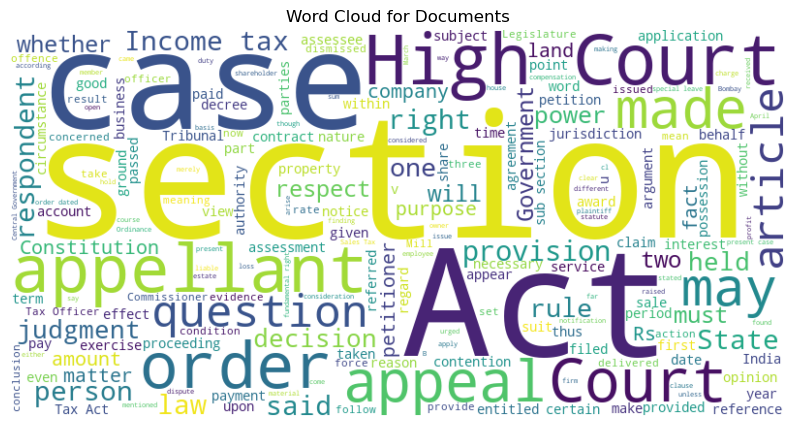

In [15]:
# Word Cloud for Documents
doc_text = ' '.join(dataset['document'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(doc_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Documents')
plt.show()

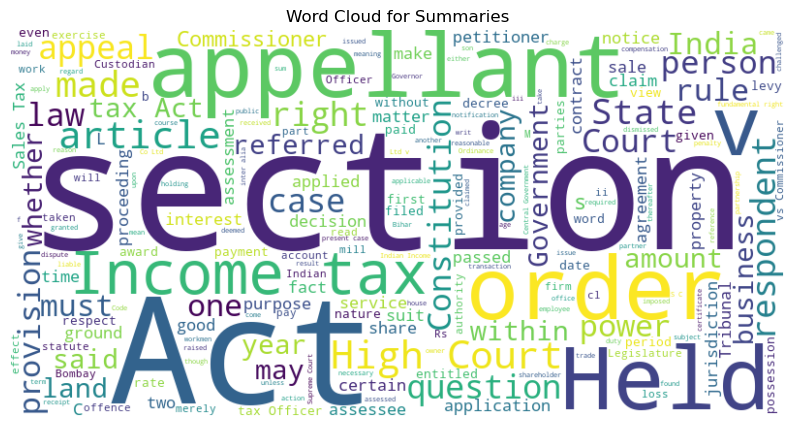

In [16]:
# Word Cloud for Summaries
summary_text = ' '.join(dataset['summary'].values)
wordcloud_summary = WordCloud(width=800, height=400, background_color='white').generate(summary_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Summaries')
plt.show()

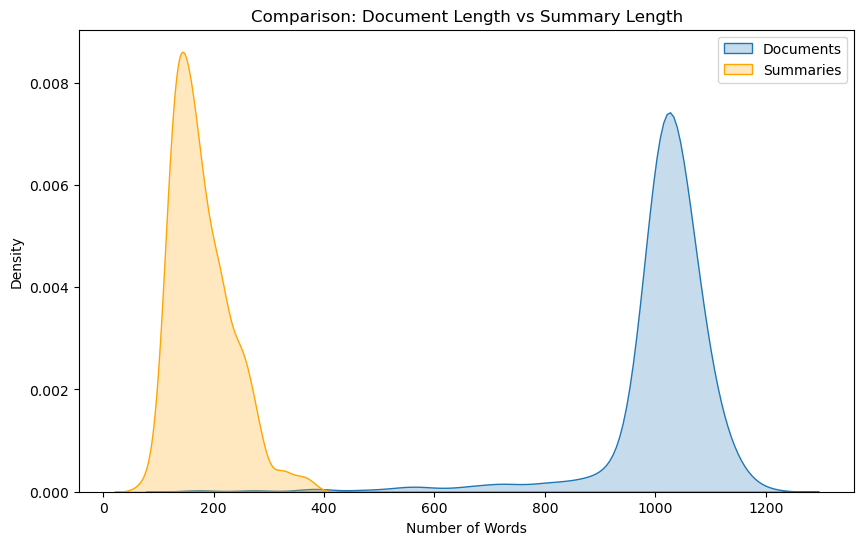

In [17]:
# Summary vs Document Length Comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(dataset['doc_length'], label='Documents', fill=True)
sns.kdeplot(dataset['summary_length'], label='Summaries', fill=True, color='orange')
plt.title('Comparison: Document Length vs Summary Length')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.legend()
plt.show()

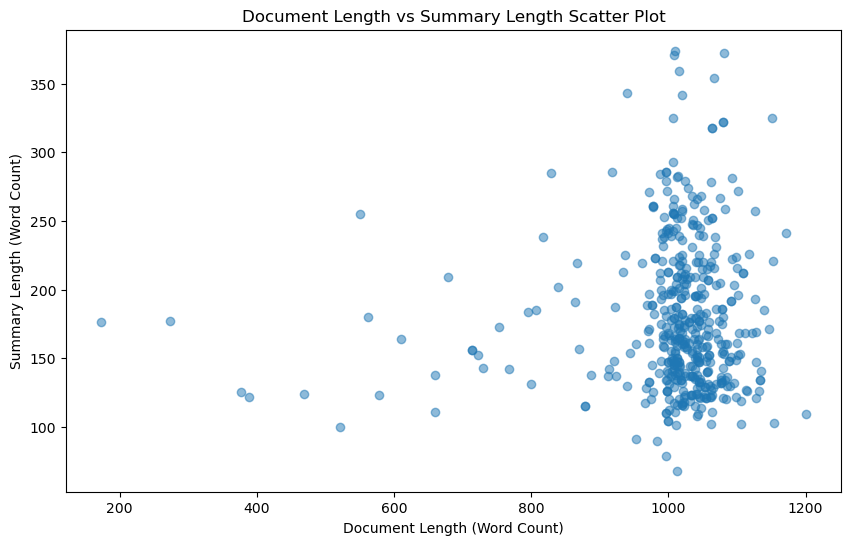

In [18]:
# Document vs Summary Token Count Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(dataset['doc_length'], dataset['summary_length'], alpha=0.5)
plt.title('Document Length vs Summary Length Scatter Plot')
plt.xlabel('Document Length (Word Count)')
plt.ylabel('Summary Length (Word Count)')
plt.show()

In [19]:
# Helper function to plot n-grams
def plot_ngrams(corpus, n=2, num_ngrams=20):
    tokens = [word for text in corpus for word in nltk.word_tokenize(text.lower())]
    ngram_freq = Counter(ngrams(tokens, n))
    most_common_ngrams = ngram_freq.most_common(num_ngrams)
    ngrams_df = pd.DataFrame(most_common_ngrams, columns=['ngram', 'count'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=ngrams_df, x='count', y=ngrams_df['ngram'].apply(lambda x: ' '.join(x)))
    plt.title(f'Top {num_ngrams} {n}-grams')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-gram')
    plt.show()


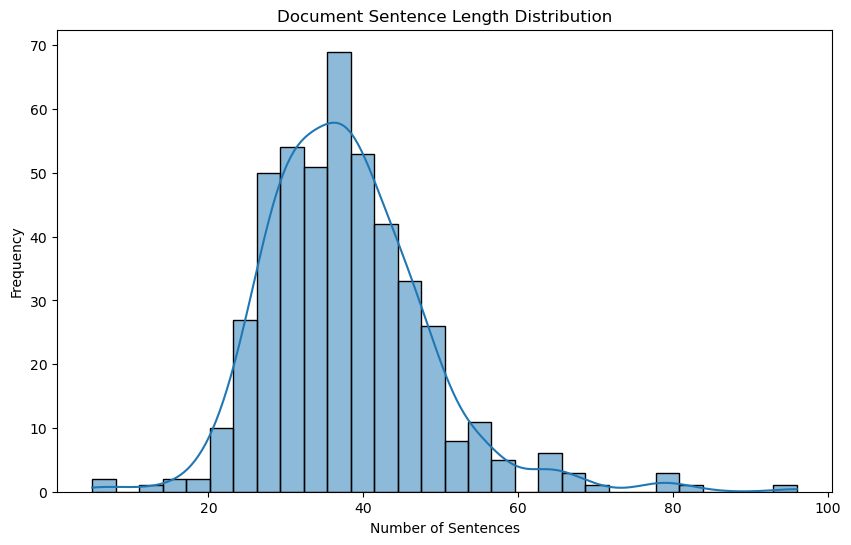

In [20]:
# Histogram of Sentence Lengths (Documents)
dataset['doc_sentence_count'] = dataset['document'].apply(lambda x: len(nltk.sent_tokenize(x)))
plt.figure(figsize=(10, 6))
sns.histplot(dataset['doc_sentence_count'], bins=30, kde=True)
plt.title('Document Sentence Length Distribution')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.show()


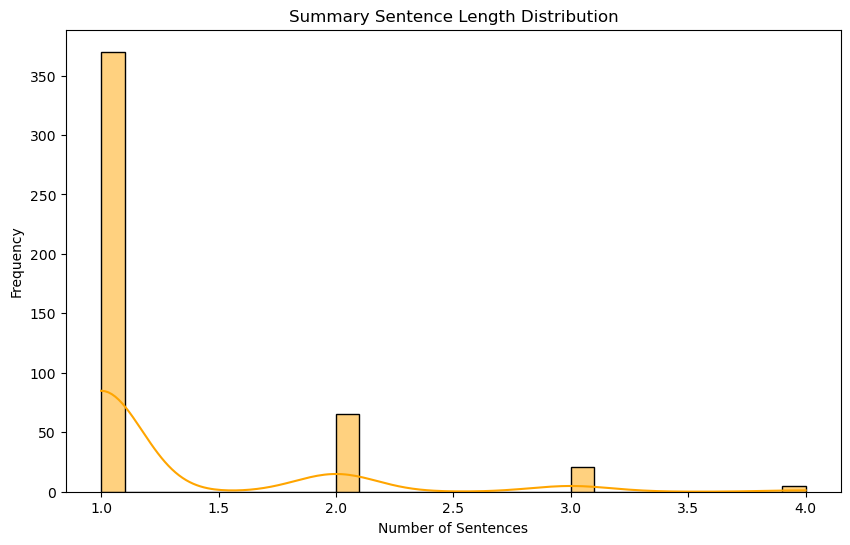

In [21]:
# Histogram of Sentence Lengths (Summaries)
dataset['summary_sentence_count'] = dataset['summary'].apply(lambda x: len(nltk.sent_tokenize(x)))
plt.figure(figsize=(10, 6))
sns.histplot(dataset['summary_sentence_count'], bins=30, kde=True, color='orange')
plt.title('Summary Sentence Length Distribution')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.show()


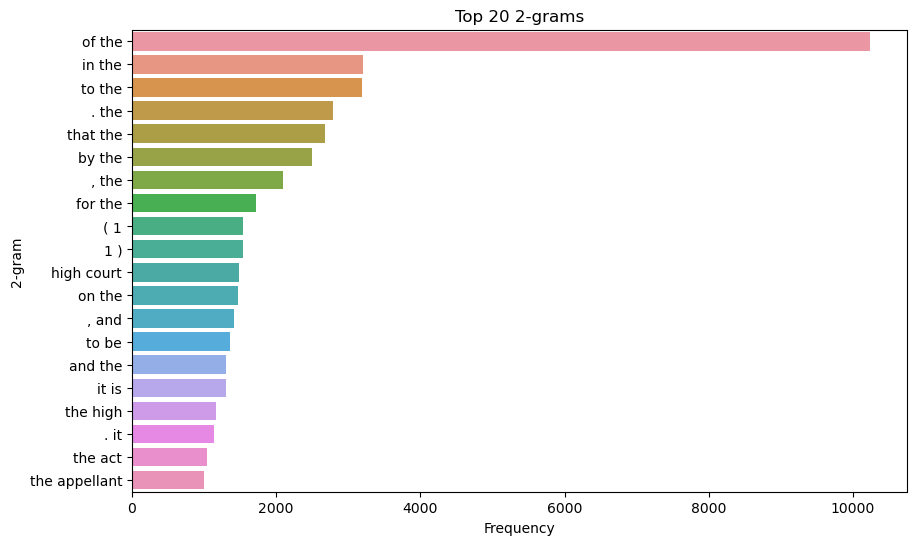

In [22]:
# N-Grams (Bigrams)
plot_ngrams(dataset['document'], n=2, num_ngrams=20)


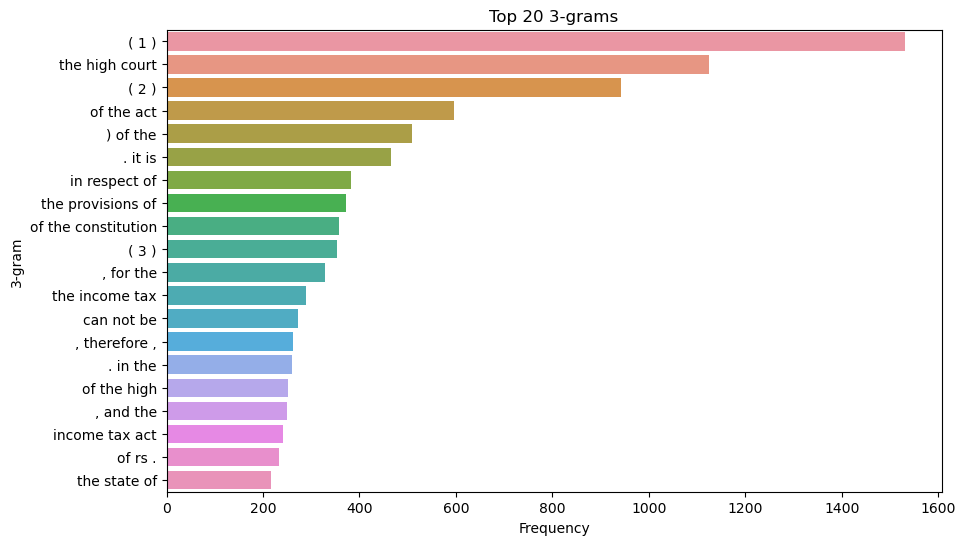

In [23]:
# N-Grams (Trigrams)
plot_ngrams(dataset['document'], n=3, num_ngrams=20)


In [ ]:
# Part-of-Speech Tagging Visualization
# Extract tokens and their POS tags
tokens_pos = nltk.pos_tag([word for text in dataset['document'] for word in nltk.word_tokenize(text)])
pos_counts = Counter(tag for word, tag in tokens_pos)
pos_df = pd.DataFrame(pos_counts.items(), columns=['POS', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(data=pos_df, x='POS', y='Count')
plt.title('Part-of-Speech Tag Distribution in Documents')
plt.xlabel('POS Tag')
plt.ylabel('Count')
plt.show()